# Wheel of emotions

In [27]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.tools import FigureFactory as FF
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation
from sklearn.model_selection import ShuffleSplit
from time import time
from collections import defaultdict

## Propose several models of classification of emotions and propose a qualitative and quantitative analysis of these models according to evaluation criteria.

In [6]:
#define stopwords and vectorizer
stopwords = nltk.corpus.stopwords.words('english')
vectoriser = CountVectorizer(ngram_range=(1,2), stop_words = stopwords )


In [106]:
#define all classification model
logreg = LogisticRegression(max_iter = 1000)
svclass = SVC()
sgdc = SGDClassifier(max_iter = 5000)
knn = KNeighborsClassifier(n_neighbors=10)
dtree = DecisionTreeClassifier(random_state=0)

#define fit and predict function
def fitting(X, y, mod):
    mod.fit(X, y)

def funcpredict(X, mod):
    xx = mod.predict(X)
    return xx

## First have to work with the dataset from Kaggle to carry out your training and the evaluation of your models.

In [4]:
#import data
df = pd.read_csv("data/emotion_final.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [6]:
#define x,y and clean data
x = np.array(df["Text"])
y = np.array(df["Emotion"])

x = vectoriser.fit_transform(x)

#define result dict

result = {}

### Logistic Regression

In [108]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

#fit and predict
fitting(x_train, y_train, logreg)
ypred = funcpredict(x_test, logreg)

NameError: name 'funcpredict' is not defined

In [8]:
logreg_f1 = f1_score(y_test, ypred, average="weighted")
logreg_recall = recall_score(y_test, ypred, average="weighted")
logreg_precision = precision_score(y_test, ypred, average="weighted")
result['logreg'] = logreg_f1, logreg_recall, logreg_precision

### SVC

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

fitting(x_train, y_train, svclass)
ypred = funcpredict(x_test, svclass)

In [10]:
svclass_f1 = f1_score(y_test, ypred, average="weighted")
svclass_recall = recall_score(y_test, ypred, average="weighted")
svclass_precision = precision_score(y_test, ypred, average="weighted")
result['svc'] = svclass_f1, svclass_recall, svclass_precision

### SGD

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

fitting(x_train, y_train, sgdc)
ypred = funcpredict(x_test, sgdc)

In [12]:
sgdc_f1 = f1_score(y_test, ypred, average="weighted")
sgdc_recall = recall_score(y_test, ypred, average="weighted")
sgdc_precision = precision_score(y_test, ypred, average="weighted")
result['sgdc'] = sgdc_f1, sgdc_recall, sgdc_precision

### KNN

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

fitting(x_train, y_train, knn)
ypred = funcpredict(x_test, knn)

In [14]:
knn_f1 = f1_score(y_test, ypred, average="weighted")
knn_recall = recall_score(y_test, ypred, average="weighted")
knn_precision = precision_score(y_test, ypred, average="weighted")
result['knn'] = knn_f1, knn_recall, knn_precision

### Decision Tree

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

fitting(x_train, y_train, dtree)
ypred = funcpredict(x_test, dtree)

In [16]:
dtree_f1 = f1_score(y_test, ypred, average="weighted")
dtree_recall = recall_score(y_test, ypred, average="weighted")
dtree_precision = precision_score(y_test, ypred, average="weighted")
result['dtree'] = dtree_f1, dtree_recall, dtree_precision

### Result - DF1

In [17]:
liste = []
values = []

for k, v in result.items():
    liste.append(k)
    values.append(v)
    
dfresult = pd.DataFrame(columns=['Model','F1_score - Recall - Precision'])

dfresult['Model'] = pd.Series(liste)
dfresult['F1_score - Recall - Precision'] = pd.Series(values)

dfresult.head()

,Model,F1_score - Recall - Precision
0,logreg,"(0.8991977253696037, 0.9007455731593662, 0.899..."
1,svc,"(0.7825518915306116, 0.7968313140726934, 0.821..."
2,sgdc,"(0.9054452061019287, 0.9065703634669152, 0.905..."
3,knn,"(0.45736459471976015, 0.4666821994408201, 0.52..."
4,dtree,"(0.8735854595419213, 0.8734855545200373, 0.874..."


In this case we can see sgdc is better

## Introduce pipeline to compare with TFID, StopWorld, N-gram

In [22]:
def run_pipes(pipes, splits=10, test_size=0.2, seed=0):  
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed)
    for idx_train, idx_test in spliter.split(corpus):
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])
            
            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]
            
            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start
            
            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                f1_score(y_test, y, average="weighted"),
                recall_score(y_test, y, average="weighted"),
                precision_score(y_test, y, average="weighted")
            ])
    return res

def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0].mean().round(2),
            "f1": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "recall": [arr[:,2].mean().round(3), arr[:,1].std().round(3)],
            "precision": [arr[:,3].mean().round(3), arr[:,1].std().round(3)],}
    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [23]:
#import data
df = pd.read_csv("data/emotion_final.csv")

corpus = np.array(df['Text'])
targets = np.array(df['Emotion'])

## Logistic Regression

In [25]:
pipe00 = Pipeline([
    ('vectSW', CountVectorizer(stop_words=stopwords)),
    ('loreg', LogisticRegression(max_iter=5000)), 
])
pipe001 = Pipeline([
    ('vect', CountVectorizer()),
    ('loreg', LogisticRegression(max_iter=5000)),
])
res = run_pipes([pipe00, pipe001])
print_table(res)

,time,f1,recall,precision
vectSW-loreg,5.13,"[0.885, 0.005]","[0.886, 0.005]","[0.885, 0.005]"
vect-loreg,8.00,"[0.88, 0.006]","[0.881, 0.006]","[0.88, 0.006]"


In [31]:
pipe002 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('loreg', LogisticRegression(max_iter=5000)), 
])
res = run_pipes([pipe002])
print_table(res)

,time,f1,recall,precision
vectSWNG-loreg,33.36,"[0.892, 0.005]","[0.894, 0.005]","[0.893, 0.005]"


In [32]:
pipe003 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('idf', TfidfTransformer()),
    ('loreg', LogisticRegression(max_iter=5000)),
])
res = run_pipes([pipe003])
print_table(res)

,time,f1,recall,precision
vectSWNG-idf-loreg,33.94,"[0.843, 0.003]","[0.85, 0.003]","[0.856, 0.003]"


__Logistic regression__ 

The better pipeline is 002, with (__stop_words, ngram__)

## SVC

In [33]:
pipe01 = Pipeline([
    ('vectSW', CountVectorizer(stop_words=stopwords)),
    ('svc', SVC(max_iter=5000, tol=1e-4)),
])
pipe011 = Pipeline([
    ('vect', CountVectorizer()),
    ('svc', SVC(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe01, pipe011])
print_table(res)

/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


,time,f1,recall,precision
vectSW-svc,51.79,"[0.824, 0.006]","[0.831, 0.006]","[0.838, 0.006]"
vect-svc,86.73,"[0.77, 0.006]","[0.783, 0.006]","[0.803, 0.006]"


In [34]:
pipe012 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('svc', SVC(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe012])
print_table(res)

/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


,time,f1,recall,precision
vectSWNG-svc,75.04,"[0.835, 0.005]","[0.843, 0.005]","[0.849, 0.005]"


In [35]:
pipe013 = Pipeline([
    ('vectSWNG', CountVectorizer(stop_words=stopwords)),
    ('idf', TfidfTransformer()),
    ('svc', SVC(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe013])
print_table(res)

/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


,time,f1,recall,precision
vectSWNG-idf-svc,49.45,"[0.849, 0.005]","[0.854, 0.005]","[0.857, 0.005]"


__SVC__ 

The better pipeline is 013, with (__stop_words, ngram, IDF__)

## SGD Classifier

In [37]:
pipe02 = Pipeline([
    ('vectSW', CountVectorizer(stop_words=stopwords)),
    ('sgd', SGDClassifier(max_iter=5000, tol=1e-4)),
])
pipe021 = Pipeline([
    ('vect', CountVectorizer()),
    ('sgd', SGDClassifier(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe02, pipe021])
print_table(res)

,time,f1,recall,precision
vectSW-sgd,0.79,"[0.888, 0.005]","[0.889, 0.005]","[0.888, 0.005]"
vect-sgd,1.20,"[0.886, 0.005]","[0.887, 0.005]","[0.886, 0.005]"


In [38]:
pipe022 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('sgd', SGDClassifier(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe022])
print_table(res)

,time,f1,recall,precision
vectSWNG-sgd,1.68,"[0.9, 0.004]","[0.9, 0.004]","[0.9, 0.004]"


In [39]:
pipe023 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('idf', TfidfTransformer()),
    ('sgd', SGDClassifier(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe023])
print_table(res)

,time,f1,recall,precision
vectSWNG-idf-sgd,1.92,"[0.897, 0.004]","[0.898, 0.004]","[0.898, 0.004]"


__SGD__ 

The better pipeline is 022, with (__stop_words, ngram__)

## KNN

In [46]:
pipe03 = Pipeline([
    ('vectSW', CountVectorizer(stop_words=stopwords)),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
])
pipe031 = Pipeline([
    ('vect', CountVectorizer()),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
])
res = run_pipes([pipe03, pipe031])
print_table(res)

,time,f1,recall,precision
vectSW-knn,0.35,"[0.551, 0.008]","[0.571, 0.008]","[0.583, 0.008]"
vect-knn,0.39,"[0.387, 0.005]","[0.415, 0.005]","[0.398, 0.005]"


In [47]:
pipe032 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
])
res = run_pipes([pipe032])
print_table(res)

,time,f1,recall,precision
vectSWNG-knn,0.98,"[0.467, 0.009]","[0.478, 0.009]","[0.537, 0.009]"


In [48]:
pipe033 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('idf', TfidfTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
])
res = run_pipes([pipe033])
print_table(res)

,time,f1,recall,precision
vectSWNG-idf-knn,0.97,"[0.757, 0.008]","[0.763, 0.008]","[0.773, 0.008]"


__KNN__ 

The better pipeline is 033, with (__stop_words, ngram, IDF__)

## DTREE

In [49]:
pipe04 = Pipeline([
    ('vectSW', CountVectorizer(stop_words=stopwords)),
    ('dtree', DecisionTreeClassifier(random_state=0)),
])
pipe041 = Pipeline([
    ('vect', CountVectorizer()),
    ('dtree', DecisionTreeClassifier(random_state=0)),
])
res = run_pipes([pipe04, pipe041])
print_table(res)

,time,f1,recall,precision
vectSW-dtree,3.09,"[0.863, 0.002]","[0.863, 0.002]","[0.865, 0.002]"
vect-dtree,3.94,"[0.849, 0.004]","[0.849, 0.004]","[0.85, 0.004]"


In [51]:
pipe042 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('dtree', DecisionTreeClassifier(random_state=0)),
])

res = run_pipes([pipe042])
print_table(res)

,time,f1,recall,precision
vectSWNG-dtree,14.45,"[0.867, 0.002]","[0.867, 0.002]","[0.869, 0.002]"


In [52]:
pipe043 = Pipeline([
    ('vectSWNG', CountVectorizer(ngram_range=(1,2), stop_words=stopwords)),
    ('idf', TfidfTransformer()),
    ('dtree', DecisionTreeClassifier(random_state=0)),
])

res = run_pipes([pipe043])
print_table(res)

,time,f1,recall,precision
vectSWNG-idf-dtree,16.31,"[0.858, 0.005]","[0.858, 0.005]","[0.859, 0.005]"


__DecisionTree__ 

The better pipeline is 042, with (__stop_words, ngram__)

## Compare models

In [54]:
#run all best pipe from each model

res = run_pipes([pipe002, pipe013, pipe022, pipe033, pipe042])
print_table(res)

/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/randon/anaconda3/envs/devia/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-pro

,time,f1,recall,precision
vectSWNG-loreg,22.40,"[0.892, 0.005]","[0.894, 0.005]","[0.893, 0.005]"
vectSWNG-idf-svc,54.08,"[0.849, 0.005]","[0.854, 0.005]","[0.857, 0.005]"
vectSWNG-sgd,1.51,"[0.9, 0.005]","[0.901, 0.005]","[0.9, 0.005]"
vectSWNG-idf-knn,0.86,"[0.757, 0.008]","[0.763, 0.008]","[0.773, 0.008]"
vectSWNG-dtree,12.13,"[0.867, 0.002]","[0.867, 0.002]","[0.869, 0.002]"


## In second have to work with the dataset from Data world to carry out your training and the evaluation of your models.

In [55]:
df2 = pd.read_csv("data/text_emotion.csv")

In [56]:
df2.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [57]:
x2 = np.array(df2["content"])
y2 = np.array(df2["sentiment"])

x2 = vectoriser.fit_transform(x2)

result2 = {}

### Logistic Regression

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.20, random_state=0)

fitting(x_train, y_train, logreg)
ypred = funcpredict(x_test, logreg)

In [59]:
logreg2_f1 = f1_score(y_test, ypred, average="weighted")
result2['logreg2_f1'] = logreg2_f1

### SVC

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.20, random_state=0)

fitting(x_train, y_train, svclass)
ypred = funcpredict(x_test, svclass)

In [61]:
svclass2_f1 = f1_score(y_test, ypred, average="weighted")
result2['svclass2_f1'] = svclass2_f1

### SGD

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.20, random_state=0)

fitting(x_train, y_train, sgdc)
ypred = funcpredict(x_test, sgdc)

In [63]:
sgdc2_f1 = f1_score(y_test, ypred, average="weighted")
result2['sgdc2_f1'] = sgdc2_f1

### KNN

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.20, random_state=0)

fitting(x_train, y_train, knn)
ypred = funcpredict(x_test, knn)

In [65]:
knn2_f1 = f1_score(y_test, ypred, average="weighted")
result2['knn2_f1'] = knn2_f1

### Decision Tree

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.20, random_state=0)

fitting(x_train, y_train, dtree)
ypred = funcpredict(x_test, dtree)

In [67]:
knn2_f1 = f1_score(y_test, ypred, average="weighted")
result2['knn2_f1'] = knn2_f1

## Analyse - dataframe 2

In [68]:
liste2 = []
values2 = []

for k, v in result2.items():
    liste2.append(k)
    values2.append(v)
    
dfresult2 = pd.DataFrame(columns=['Model','F1_score'])

dfresult2['Model'] = pd.Series(liste2)
dfresult2['F1_score'] = pd.Series(values2)

print(dfresult2)

         Model  F1_score
0   logreg2_f1  0.311479
1  svclass2_f1  0.291445
2     sgdc2_f1  0.299419
3      knn2_f1  0.275583


With this result, useless to try to perform the model, result is too low.

## On the one hand, compare whether the classification results on your first dataset are similar with the second. Comment.

We can see the first dataset are very better than the second. 

The best classifier on first dataset are : __SGD Classifier__

    With this F1_score : 0.9
        
The best classier on seconde dataset are : __Logistic Regression__

    With this F1_score : 0.311
    
The first dataset is very better than the second. Maybe we have so much targets on the second or the corpus need more preproccessing.
In first we will try to predict the corpus of second classifier on the targets of first classifier to observe result.

We will use the best classifier for the first dataset : __SGD Classifier__

## Predict the new emotions present in this first message dataset, and observe if the results are relevant.

In [85]:
df = pd.read_csv("data/emotion_final.csv")
df2 = pd.read_csv("data/text_emotion.csv")

### Predicted a type words

In [132]:
targets = list(df["Emotion"])
corpus = list(df["Text"])

X = corpus
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

pipe91 = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('sgd', SGDClassifier()),])
pipe91.fit(X_train, y_train)
y_pred =pipe91.predict(X_test)


# pick a string and test it 
labels = ['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']
def get_text():
  while True:
    text = input("Pick a text: ")
    if isinstance(text, str) :
        return text
    else:
      print("Try again...")


In [136]:
ltext = []
text = get_text()
ltext.append(text)
y_pred =pipe91.predict(ltext)
print(y_pred)

Pick a text: i lost my phone
['sadness']


### Predict the second df on the first train

In [137]:
y2 = list(df2["content"])

y_pred2 =pipe91.predict(y2)

print(y2[:5])
print(y_pred2[:5])

['@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[', 'Layin n bed with a headache  ughhhh...waitin on your call...', 'Funeral ceremony...gloomy friday...', 'wants to hang out with friends SOON!', '@dannycastillo We want to trade with someone who has Houston tickets, but no one will.']
['sadness' 'anger' 'sadness' 'happy' 'sadness']



## Combine the two datasets to try to improve your prediction results.

## Make some graph for the dash rendering

### The histogram representing the frequency of appearance of words (comment)

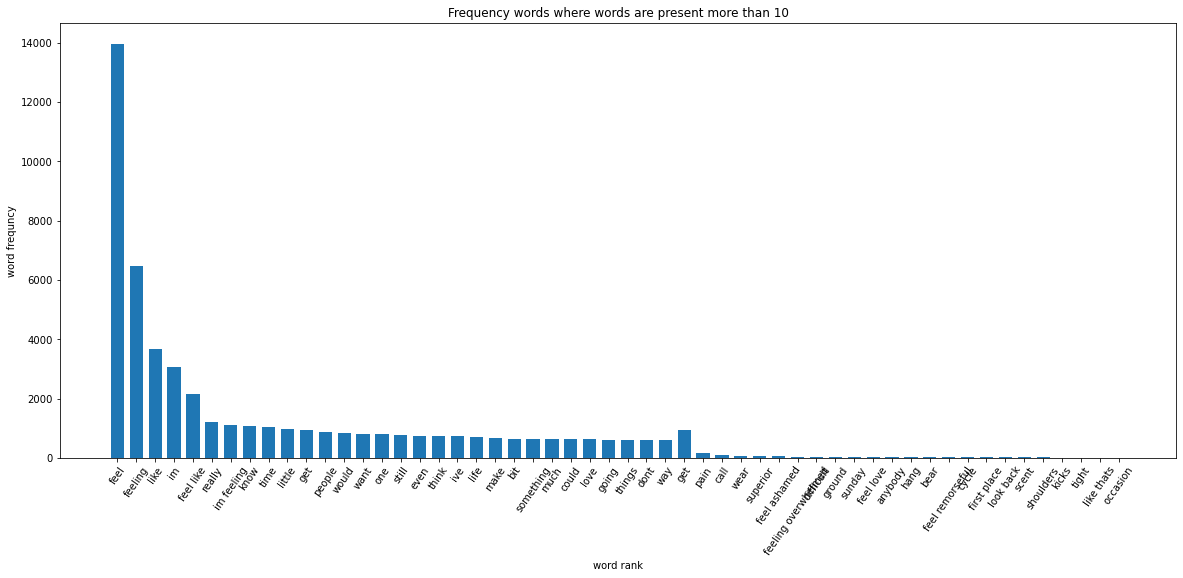

In [12]:
x = np.array(df["Text"])
y = np.array(df["Emotion"])

vec = CountVectorizer(ngram_range=(1,2), stop_words = stopwords, min_df=10 )


X = vec.fit_transform(x)
words = vec.get_feature_names()

wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

def subsample(x, step=150):
    return np.hstack((x[:30], x[10::step]))


plt.figure(figsize=(20,8))
freq = subsample(wrank)
r = np.arange(len(freq))
plt.bar(r, freq, width=0.7)
plt.xticks(r, subsample(labels), rotation=55)
plt.xlabel('word rank')
plt.ylabel('word frequncy')
plt.title("Frequency words where words are present more than 10");

In [36]:
x = np.array(df["Text"])
y = np.array(df["Emotion"])

vec = CountVectorizer(ngram_range=(1,2), stop_words = stopwords, min_df=10 )


X = vec.fit_transform(x)
words = vec.get_feature_names()

wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

def subsample(x, step=150):
    return np.hstack((x[:30], x[10::step]))

freq = subsample(wrank)
r = np.arange(len(freq))

trace = go.Histogram(x=freq, xbins=dict(),
                   marker=dict(color='rgb(0, 0, 100)'))

layout = go.Layout(
    title="Frequency Emotions Counts"
)

fig = go.Figure(data=go.Data([trace]), layout=layout)
iplot(fig, filename='histogram-freq-counts')

We see that the most present words are words like feel, feeling, like, really, these are words which cannot determine an emotion. may it be relevant to remove them

### Histogram of emotions (comment)

In [38]:
x = df["Emotion"]

trace = go.Histogram(x=x, xbins=dict(),
                   marker=dict(color='#810303'))

layout = go.Layout(
    title="Frequency Emotions Counts"
)

fig = go.Figure(data=go.Data([trace]), layout=layout)
iplot(fig, filename='histogram-freq-counts')